In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [4, 4]
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [3]:
!ls ../mini_cinic10/

classes_and_names.csv
images
README.txt
test.npz
train.npz
val.npz


In [5]:
PATH_TO_DATA = os.path.join("..", "mini_cinic10")

train_data = np.load(os.path.join(PATH_TO_DATA, "train.npz"))
val_data   = np.load(os.path.join(PATH_TO_DATA, "val.npz"))
# test_data  = np.load(os.path.join(PATH_TO_DATA, "test.npz")) # assume this doesn't exist

In [137]:
xs, ys = train_data['xs'], train_data['ys']

In [138]:
xs_val, ys_val = val_data['xs'], val_data['ys']

In [13]:
print(xs.shape, xs.dtype) # 3072 = 3 * 1024 = 3 * (32 * 32)
print(ys.shape, ys.dtype)

(80000, 3072) uint8
(80000,) uint8


In [78]:
IMG_WIDTH = IMG_HEIGHT = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # RGB images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH*3, )

# classes_and_names.csv
CLASS_NAME = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
CLASS_COUNT = len(CLASS_NAME)

In [21]:
def unravel(flat_img):
    ''' Reverts a flattened image back into a 3-layer RGB matrix representation '''
    return flat_img.reshape(IMG_SHAPE)

In [28]:
def show_image(img_index, xs, ys, figsize=None):
    ''' Shows the image represented by img_index-th row of xs '''
    if figsize:
        fig = plt.figure(figsize=figsize)
    plt.imshow(unravel(xs[img_index]))
    plt.title(f'idx #{img_index} ({CLASS_NAME[ys[img_index]]})')
    plt.axis(False)
    plt.show()

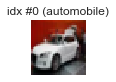

In [29]:
show_image(0, xs, ys, [1, 1])

In [139]:
print(f"mean={xs.mean():>8.4f}, stddev={xs.std():>7.4f}")
print(f"mean={ys.mean():>8.4f}, stddev={ys.std():>7.4f}")

# TODO use stats from train data to normalize the val and test sets aswell
mean, std = xs.mean(), xs.std()
xs = (xs - mean) / std
xs_val = (xs_val - mean) / std

print(f"mean={xs.mean():>8.4f}, stddev={xs.std():>7.4f}")
print(f"mean={ys.mean():>8.4f}, stddev={ys.std():>7.4f}")

mean=117.3316, stddev=63.1088
mean=  4.4833, stddev= 2.8705
mean=  0.0000, stddev= 1.0000
mean=  4.4833, stddev= 2.8705


In [ ]:
# jupyter nbconvert PreAssignment2.ipynb --to="python" --output-dir="." --output="pre-assignment2"

In [84]:
def one_hot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [143]:
onehot_ys = one_hot_encode(ys)

In [144]:
np.append(ys.reshape((-1, 1)), onehot_ys, axis=1)[0:4]

array([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [6., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [3., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

# Keras

In [67]:
import tensorflow as tf
from tensorflow import keras

In [68]:
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.regularizers import l1_l2 # l1 * sum(abs(w)) + l2 * sum(square(w))
from tensorflow.keras.optimizers import Adam

#callbacks to be used during training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [70]:
keras.__version__

'2.2.4-tf'

In [116]:
def get_logistic_regression_model(optimizer='adam'):
    __input  = Input(shape=IMG_FLAT_SHAPE)
    __output = Dense(CLASSES_COUNT, activation='softmax', kernel_regularizer=l1_l2())(__input)
    
    model = Model(inputs=__input, outputs=__output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [140]:
logreg = get_logistic_regression_model(optimizer=Adam(lr=3e-5))
logreg.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [141]:
def train(model, xs, ys, n_epochs=64, batch_size=1250, validation_frac=0.2, patience=5, early_stopping=True, **kwargs):
    callbacks = [
        ModelCheckpoint(
            monitor='val_loss',
            filepath='best_model.h5',
            save_best_only=True,
        )
    ]
    
    if early_stopping:
        callbacks.append(EarlyStopping(
            monitor='val_loss',
            min_delta=0.0003,
            patience=patience,
        ))

    history = model.fit(
        x=xs, y=ys,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_split=validation_frac,
        callbacks=callbacks,
        **kwargs
    ).history
    
    if os.path.exists('best_model.h5'):
        model = load_model('best_model.h5')
        
    return model, history

In [145]:
logreg, history = train(logreg, xs, onehot_ys)

Train on 64000 samples, validate on 16000 samples
Epoch 1/64
64000/64000 [==============================] - 1s 21us/sample - loss: 7.9374 - accuracy: 0.2382 - val_loss: 7.7814 - val_accuracy: 0.2364
Epoch 2/64
64000/64000 [==============================] - 1s 23us/sample - loss: 7.6217 - accuracy: 0.2463 - val_loss: 7.4693 - val_accuracy: 0.2447
Epoch 3/64
64000/64000 [==============================] - 1s 21us/sample - loss: 7.3131 - accuracy: 0.2514 - val_loss: 7.1645 - val_accuracy: 0.2514
Epoch 4/64
64000/64000 [==============================] - 1s 20us/sample - loss: 7.0116 - accuracy: 0.2578 - val_loss: 6.8668 - val_accuracy: 0.2573
Epoch 5/64
64000/64000 [==============================] - 1s 20us/sample - loss: 6.7171 - accuracy: 0.2638 - val_loss: 6.5763 - val_accuracy: 0.2611
Epoch 6/64
64000/64000 [==============================] - 1s 20us/sample - loss: 6.4300 - accuracy: 0.2676 - val_loss: 6.2926 - val_accuracy: 0.2653
Epoch 7/64
64000/64000 [==============================] 

64000/64000 [==============================] - 1s 22us/sample - loss: 2.1510 - accuracy: 0.2823 - val_loss: 2.1533 - val_accuracy: 0.2825
Epoch 56/64
64000/64000 [==============================] - 2s 24us/sample - loss: 2.1507 - accuracy: 0.2838 - val_loss: 2.1532 - val_accuracy: 0.2816
Epoch 57/64
64000/64000 [==============================] - 2s 25us/sample - loss: 2.1508 - accuracy: 0.2828 - val_loss: 2.1526 - val_accuracy: 0.2831
Epoch 58/64
64000/64000 [==============================] - 1s 23us/sample - loss: 2.1503 - accuracy: 0.2831 - val_loss: 2.1525 - val_accuracy: 0.2815
Epoch 59/64
64000/64000 [==============================] - 1s 23us/sample - loss: 2.1501 - accuracy: 0.2829 - val_loss: 2.1524 - val_accuracy: 0.2839
Epoch 60/64
64000/64000 [==============================] - 2s 26us/sample - loss: 2.1498 - accuracy: 0.2837 - val_loss: 2.1520 - val_accuracy: 0.2816
Epoch 61/64
64000/64000 [==============================] - 1s 23us/sample - loss: 2.1498 - accuracy: 0.2831 - va

In [146]:
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import colors as mpl_colors
plt.rcParams['figure.figsize'] = [12, 8]
style.use('ggplot')

def get_colors():
    colors = [
        '#348ABD',
        '#E24A33',
        '#A60628',
        '#467821',
        '#CF4457',
        '#7A68A6',
        '#188487',
    ]
    init_colors = set(colors)
    other_colors = sorted(mpl_colors.cnames.keys())
    colors.extend(c for c in other_colors if c not in init_colors)
    return colors


def _plot_train_history(hist):
    keys = sorted(hist.keys())
    for k, c in zip(keys, get_colors()):
        plt.plot(hist[k], color=c)
    plt.legend(keys, loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('metric')
    plt.title('train metrics')
    plt.show()
    

def plot_train_history(hist):
    _plot_train_history({'loss': hist['loss'], 'val_loss': hist['val_loss']})
    _plot_train_history({'accuracy': hist['accuracy'], 'val_accuracy': hist['val_accuracy']})

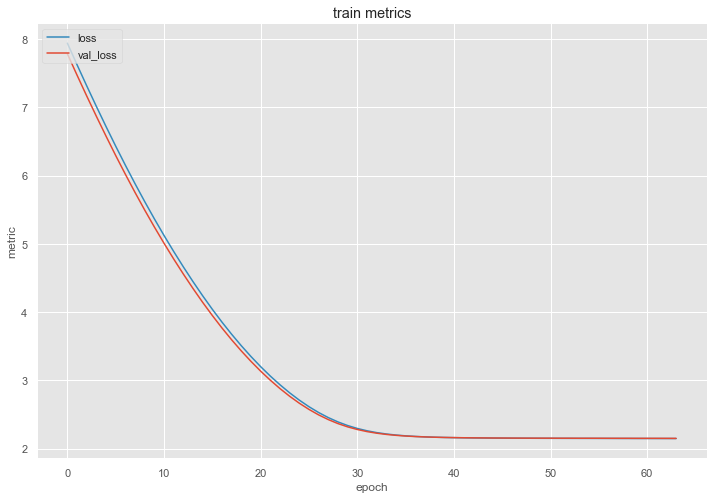

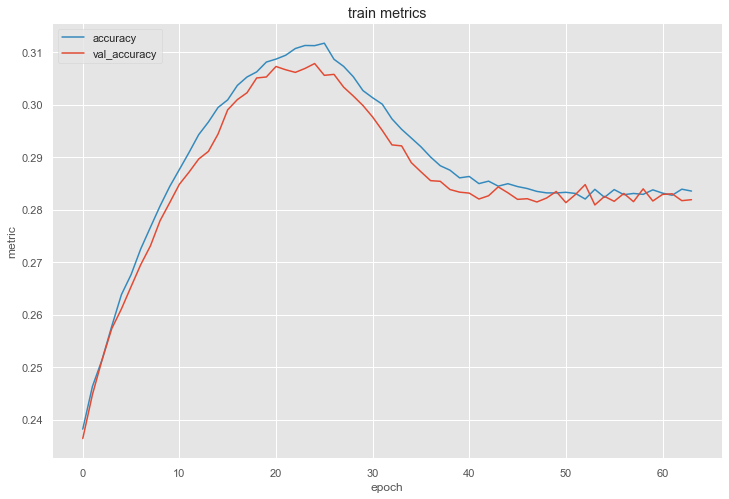

In [147]:
plot_train_history(history)

In [148]:
onehot_ys_val = one_hot_encode(ys_val)
logreg.evaluate(xs_val, onehot_ys_val)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.153740584754944, 0.2851]